In [1]:
# default_exp gan.model

# gan.model

> API details.

In [2]:
# export

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from functools import partial
from torch.nn import BCELoss, CrossEntropyLoss
from tqdm import tqdm

from fastrenewables.synthetic_data import SineDataset, plot_sine_samples
from fastrenewables.timeseries.model import TemporalCNN
from fastrenewables.tabular.model import EmbeddingModule

In [3]:
# hide

n_samples = 100
n_classes = 2
n_features = 1
len_ts = 96
batch_size = 16

n_z = 100
n_in = n_features
n_hidden = 4
epochs = 100

In [4]:
# export

def flatten_ts(x):
    """assumes matrix of shape (n_samples, n_features, ts_length)"""
    if len(x.shape) in [1,2]:
        return x

    n_samples, n_features, ts_length = x.shape

    if isinstance(x, np.ndarray):
        x = x.swapaxes(1,2)
    else:
        x = x.permute(0,2,1)
    x = x.reshape(n_samples*ts_length, n_features)
    return x

In [5]:
# export

def LinBnAct(si, so, use_bn, act_cls):
    layers = [nn.Linear(si, so)]
    if use_bn:
        layers += [nn.BatchNorm1d(so)]
    if act_cls is not None:
        layers += [act_cls]
    
    return nn.Sequential(*layers)

In [6]:
# export

class GANMLP(torch.nn.Module):
    def __init__(self, ann_structure, len_ts=1, bn_cont=False, act_fct=torch.nn.ReLU, final_act_fct=nn.Sigmoid, embedding_module=None, transpose=False):
        super(GANMLP, self).__init__()
        
        n_cont = ann_structure[0]
        if embedding_module is not None:
            emb_sz = []
            ann_structure[0] = ann_structure[0] + embedding_module.no_of_embeddings

        self.embedding_module = embedding_module
        
        layers = []
        for idx in range(1, len(ann_structure)):
            cur_use_bn = bn_cont
            cur_act_fct = act_fct()
            if idx == 1 and not bn_cont:
                cur_use_bn = False
            if idx == len(ann_structure)-1:
                cur_act_fct = None
                cur_use_bn = False
                
            layer = LinBnAct(ann_structure[idx-1]*len_ts, ann_structure[idx]*len_ts, cur_use_bn, cur_act_fct)
            layers.append(layer)
        if final_act_fct is not None:
            layers.append(final_act_fct())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x_cat, x_cont):
        if self.embedding_module is not None:
            x_cat = x_cat.squeeze(1)
            x_cat = self.embedding_module(x_cat)
            x_cat = x_cat.unsqueeze(1)
            x_cont = torch.cat([x_cat, x_cont], 2)
        
        return self.model(x_cont)

In [7]:
? EmbeddingModule

Init signature:
 EmbeddingModule(
    categorical_dimensions,
    embedding_dropout=0.0,
    embedding_dimensions=None,
    embedding_type=<EmbeddingType.Normal: 0>,
    names=None,
    **kwargs,
)
Docstring:      A container module for a number of embeddings for categorical features.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           /mnt/work/transfer/workspace/mjessulat/repos/fastrenewables/fastrenewables/tabular/model.py
Type:           type
Subclasses:     


In [8]:
emb = EmbeddingModule(categorical_dimensions=[n_classes])
#emb(torch.randn(8, n_classes).long())

GANMLP(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(2, 2)
    )
  )
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=98, out_features=384, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=384, out_features=2, bias=True)
    )
    (2): Sigmoid()
  )
)


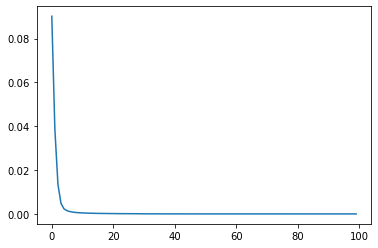

In [9]:
# hide

model = GANMLP(ann_structure=[n_in*len_ts, n_hidden*len_ts, 1*n_classes], embedding_module=emb)
print(model)
opt = torch.optim.Adam(params=model.parameters())
loss = torch.nn.MSELoss()
data = SineDataset(n_samples, n_classes, n_features, len_ts)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
#plot_sine_samples(dl)

errors = []

for epoch in range(epochs):
    for x_cat, x_cont, y in dl:
        opt.zero_grad()
        pred = model(x_cat.long(), x_cont)
        error = loss(pred, y)
        error.backward()
        opt.step()
    errors.append(error.item())
    
assert(errors[0] > errors[-1]) 

plt.figure()
plt.plot(errors)
plt.show()

In [10]:
# export

#class GANCNN(torch.nn.Module):
#    def __init__(self, ann_structure, n_z=100, len_ts=1, bn_cont=False, act_fct=nn.ReLU, final_act_fct=nn.Sigmoid, embedding_module=None, transpose=False):
#        super(GANCNN, self).__init__()
#        
#        self.conv_net = TemporalCNN(cnn_structure=ann_structure, batch_norm_cont=bn_cont, 
#                                    cnn_type='cnn', act_func=act_fct, 
#                                    # TODO: this is not the final layer
#                                    final_activation=act_fct, transpose=transpose)
#        self.transpose = transpose
#        if self.transpose:
#            if final_act_fct is not None:
#                self.model_in = nn.Sequential(nn.Linear(n_z, ann_structure[0]*len_ts), final_act_fct(),
#                                          nn.Unflatten(1, (ann_structure[0], len_ts))
#                                         )
#            else:
#                self.model_in = nn.Sequential(nn.Linear(n_z, ann_structure[0]*len_ts),
#                                          nn.Unflatten(1, (ann_structure[0], len_ts))
#                                         )
#        if not self.transpose:
#            # TODO ugly
#            if final_act_fct is not None:
#                self.model_out = nn.Sequential(nn.Flatten(), nn.Linear(len_ts, len_ts), final_act_fct())
#            else:
#                self.model_out = nn.Sequential(nn.Flatten(), nn.Linear(len_ts, len_ts))
#        
#    def forward(self, x_cat, x_cont):
#        if self.transpose:
#            x = self.model_in(x_cont)
#            x = self.conv_net(x_cat, x)
#        else: 
#            x = self.conv_net(x_cat, x_cont)
#            x = self.model_out(x)
#        return x

In [11]:
# hide

#model = GANCNN(ann_structure=[n_in, n_hidden, 1], n_z=100, len_ts=24, transpose=False)
#print(model)
#opt = torch.optim.Adam(params=model.parameters())
#loss = torch.nn.MSELoss()
#data = DummyDataset(n_samples=100, n_cat_feats=n_in, n_cont_feats=n_in, n_targets=1, n_dim=3)
#dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)
#
#errors = []
#
#for epoch in range(epochs):
#    for x_cat, x_cont, y in dl:
#        opt.zero_grad()
#        pred = model(x_cat, x_cont)
#        error = loss(pred, y)
#        error.backward()
#        opt.step()
#    errors.append(error.item())
#    
#assert(errors[0] > errors[-1]) 
#
#plt.figure()
#plt.plot(errors)
#plt.show()

In [12]:
# export
    
class GAN(nn.Module):
    
    def __init__(self, generator, discriminator, gen_optim, dis_optim, n_z=100, auxiliary=False, auxiliary_weighting_factor=1):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.n_z = n_z
        self.real_loss = []
        self.fake_loss = []
        self.auxiliary = auxiliary
        self.bce_loss = BCELoss()
        self.auxiliary_loss_function = CrossEntropyLoss()
        self.auxiliary_weighting_factor=auxiliary_weighting_factor
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.to_device(self.device)
        
    def noise(self, x):
        z = torch.randn(x.shape[0], 1, self.n_z).to(self.device)
        return z
    
    def to_device(self, device):
        self.device = device
        self.generator = self.generator.to(device)
        self.discriminator = self.discriminator.to(device)
        self.bce_loss = self.bce_loss.to(device)
        self.auxiliary_loss_function = self.auxiliary_loss_function.to(device)
        
    def _split_pred(self, y):
        if self.auxiliary:
            y, class_probs = y
        else:
            y, class_probs = y, None
        return y, class_probs
    
    def auxiliary_loss(self, class_probs, y):
        # class_probs and targets should be of the same shape (N, n_classes)!
        class_probs = class_probs.squeeze(1)
        y = y.squeeze(1)
        return self.auxiliary_loss_function(class_probs, y)*self.auxiliary_weighting_factor
    
    def train_generator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(None, x_cont_fake)  
        y_fake, class_probs = self._split_pred(y_fake)
        loss = self.bce_loss(y_fake, torch.ones_like(y_fake))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            loss = (loss + aux_loss)/2
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        y_real = self.discriminator(None, x_cont)
        y_real, class_probs = self._split_pred(y_real)
        real_loss = self.bce_loss(y_real, torch.ones_like(y_real))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            real_loss = (real_loss + aux_loss)/2
        
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(None, x_cont_fake)
        y_fake, class_probs = self._split_pred(y_fake)
        
        fake_loss =  self.bce_loss(y_fake, torch.zeros_like(y_fake))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            fake_loss = (fake_loss + aux_loss)/2
            
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        return
    
    def forward(self, x_cat, x_cont):
        z = self.noise(x_cont)
        x_gen = self.generator(x_cat, z)
        assert(x_gen.shape == x_cont.shape)
        y = self.discriminator(None, x_gen)
        out = self._split_pred(y)
        return out

GAN(
  (generator): GANMLP(
    (embedding_module): EmbeddingModule(
      (embeddings): ModuleList(
        (0): Embedding(2, 2)
      )
    )
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=102, out_features=384, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=384, out_features=96, bias=True)
      )
      (2): Sigmoid()
    )
  )
  (discriminator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=96, out_features=384, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=384, out_features=96, bias=True)
      )
      (2): Sigmoid()
    )
  )
  (bce_loss): BCELoss()
  (auxiliary_loss_function): CrossEntropyLoss()
)


100%|██████████| 100/100 [00:06<00:00, 14.58it/s]


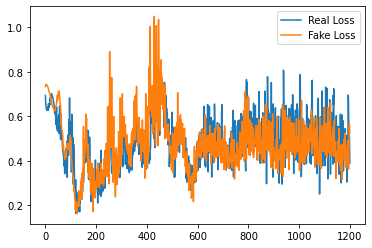

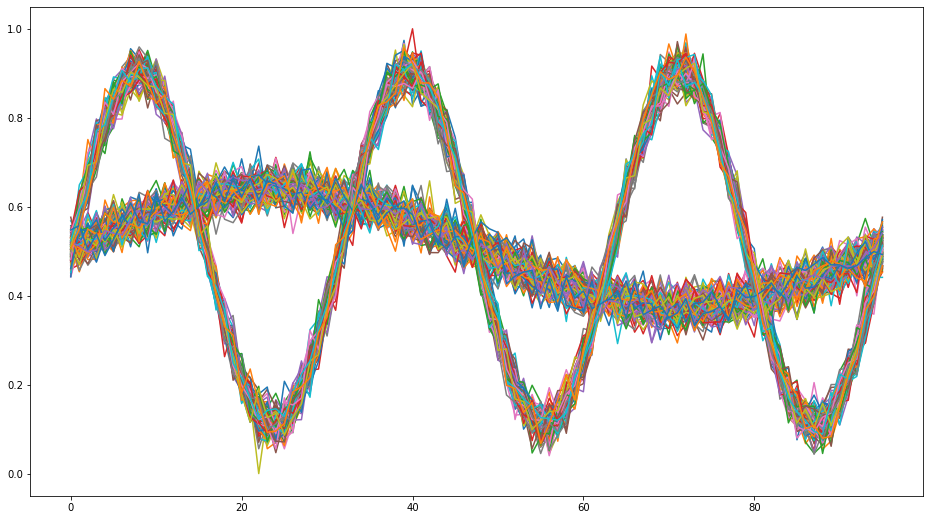

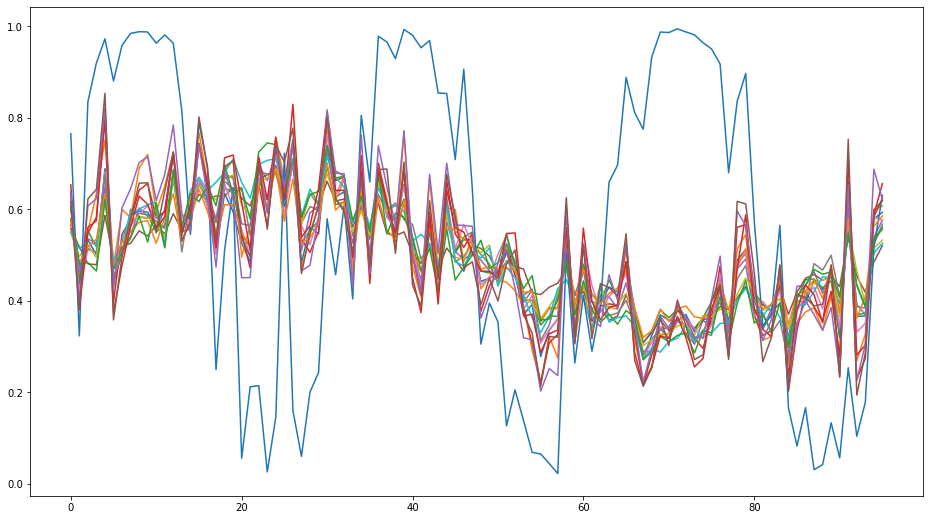

In [13]:
#hide

generator = GANMLP([n_z, n_hidden*len_ts, n_in*len_ts], embedding_module=emb)
discriminator = GANMLP([n_in*len_ts, n_hidden*len_ts, 1*len_ts])
gen_opt = torch.optim.Adam(generator.parameters())
dis_opt = torch.optim.Adam(discriminator.parameters())
model = GAN(generator, discriminator, gen_opt, dis_opt, n_z=n_z)
print(model)

data = SineDataset(n_samples, n_classes, n_features, len_ts)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

for e in tqdm(range(epochs)):
    for x_cat, x_cont, y in dl:
        x_cat = x_cat.to(model.device).long()
        x_cont = x_cont.to(model.device)
        y = y.to(model.device)

        model.train_discriminator(x_cat, x_cont, y)
        model.train_generator(x_cat, x_cont, y)

plt.figure()
plt.plot(model.real_loss, label='Real Loss')
plt.plot(model.fake_loss, label='Fake Loss')
plt.legend()
plt.show()

assert(np.abs(model.real_loss[-1] - model.fake_loss[-1]) < 0.5)

z = model.noise(x_cont)
x_fake = model.generator(x_cat, z)
assert((x_fake - x_cont).mean().abs().item() < 0.5)

plot_sine_samples(dl)
plt.figure(figsize=(16, 9))
for idx in range(x_fake.shape[0]):
    plt.plot(x_fake.squeeze(1)[idx, :].cpu().detach().numpy())
plt.show()

In [14]:
# export

class WGAN(GAN):
    def __init__(self, generator, discriminator, gen_optim, dis_optim, n_z=100, clip=0.001, auxiliary=False):
        super(WGAN, self).__init__(generator, discriminator, gen_optim, dis_optim, n_z, clip, auxiliary)
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.n_z = n_z
        self.clip = clip
        self.auxiliary = auxiliary
        self.real_loss = []
        self.fake_loss = []
        
    def train_generator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(None, x_cont_fake)
        loss = - y_fake.mean()
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        y_real = self.discriminator(None, x_cont)
        real_loss = - y_real.mean()
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(None, x_cont_fake)
        fake_loss = y_fake.mean()
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        
        for p in self.discriminator.parameters():
            p = torch.clamp(p, -self.clip, self.clip)
        return

WGAN(
  (generator): GANMLP(
    (embedding_module): EmbeddingModule(
      (embeddings): ModuleList(
        (0): Embedding(2, 2)
      )
    )
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=102, out_features=384, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=384, out_features=96, bias=True)
      )
      (2): Sigmoid()
    )
  )
  (discriminator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=96, out_features=384, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=384, out_features=96, bias=True)
      )
    )
  )
  (bce_loss): BCELoss()
  (auxiliary_loss_function): CrossEntropyLoss()
)


100%|██████████| 100/100 [00:05<00:00, 18.28it/s]


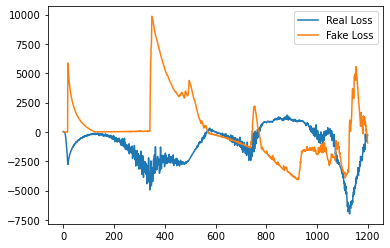

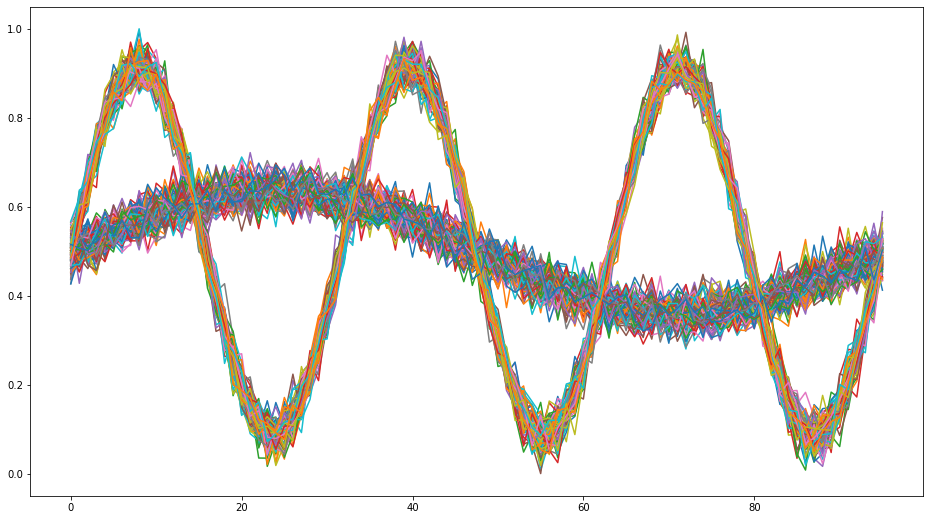

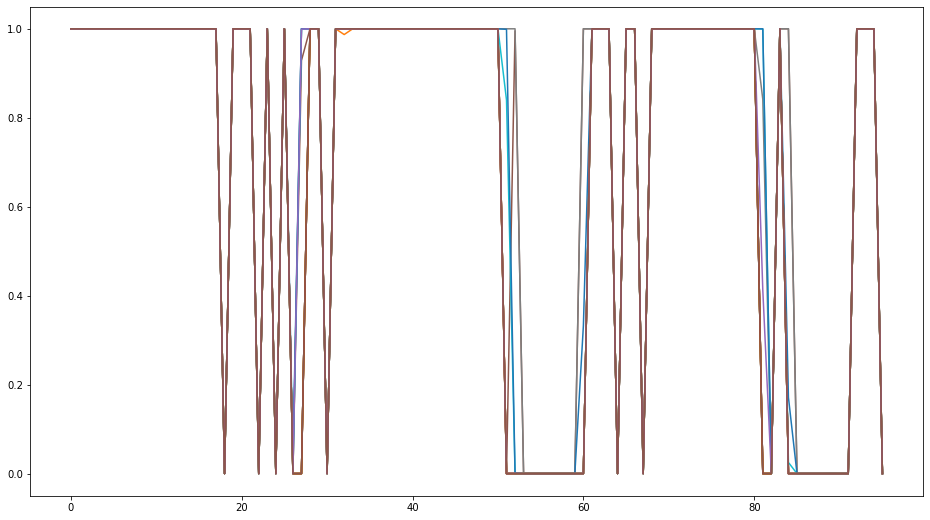

In [15]:
#hide

generator = GANMLP([n_z, n_hidden*len_ts, n_in*len_ts], embedding_module=emb)
discriminator = GANMLP([n_in*len_ts, n_hidden*len_ts, 1*len_ts], final_act_fct=None)
gen_opt = torch.optim.RMSprop(generator.parameters())
dis_opt = torch.optim.RMSprop(discriminator.parameters())
model = WGAN(generator, discriminator, gen_opt, dis_opt, n_z=n_z)
print(model)

data = SineDataset(n_samples, n_classes, n_features, len_ts)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

for e in tqdm(range(epochs)):
    for x_cat, x_cont, y in dl:
        x_cat = x_cat.to(model.device).long()
        x_cont = x_cont.to(model.device)
        y = y.to(model.device)

        model.train_discriminator(x_cat, x_cont, y)
        model.train_generator(x_cat, x_cont, y)

plt.figure()
plt.plot(model.real_loss, label='Real Loss')
plt.plot(model.fake_loss, label='Fake Loss')
plt.legend()
plt.show()

z = model.noise(x_cont)
x_fake = model.generator(x_cat, z)
assert((x_fake - x_cont).mean().abs().item() < 0.5)

plot_sine_samples(dl)
plt.figure(figsize=(16, 9))
for idx in range(x_fake.shape[0]):
    plt.plot(x_fake.squeeze(1)[idx, :].cpu().detach().numpy())
plt.show()

In [16]:
x_fake.shape

torch.Size([16, 1, 96])

In [17]:
#export    

class AuxiliaryDiscriminator(torch.nn.Module):
    def __init__(self, basic_discriminator, n_classes, final_input_size, len_ts=1):
        super(AuxiliaryDiscriminator, self).__init__()
        self.basic_discriminator = basic_discriminator
        self.n_classes = n_classes
        self.final_input_size = final_input_size
        self.len_ts = len_ts
        
        self.adv_layer = nn.Sequential(nn.Linear(self.final_input_size*len_ts, len_ts), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(self.final_input_size*len_ts, n_classes), nn.Softmax(dim=1))
        
    def forward(self, cats, conts):
        out = self.basic_discriminator(cats, conts)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return (validity, label)

In [18]:
loss = nn.CrossEntropyLoss()
class_probs = torch.rand(3, 5, requires_grad=True)
y = torch.rand(3, 5).softmax(dim=1)
output = loss(class_probs, y)
print(class_probs.shape, y.shape)

torch.Size([3, 5]) torch.Size([3, 5])


GAN(
  (generator): GANMLP(
    (embedding_module): EmbeddingModule(
      (embeddings): ModuleList(
        (0): Embedding(2, 2)
      )
    )
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=102, out_features=384, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=384, out_features=96, bias=True)
      )
      (2): Sigmoid()
    )
  )
  (discriminator): AuxiliaryDiscriminator(
    (basic_discriminator): GANMLP(
      (model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=96, out_features=384, bias=True)
        )
        (1): ReLU()
      )
    )
    (adv_layer): Sequential(
      (0): Linear(in_features=384, out_features=96, bias=True)
      (1): Sigmoid()
    )
    (aux_layer): Sequential(
      (0): Linear(in_features=384, out_features=2, bias=True)
      (1): Softmax(dim=1)
    )
  )
  (bce_loss): BCELoss()
  (auxiliary_loss_function): CrossEntropyLoss()
)


100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


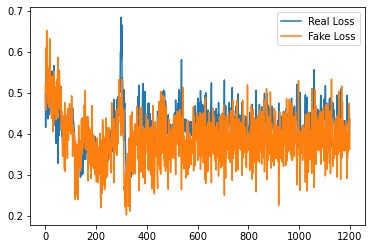

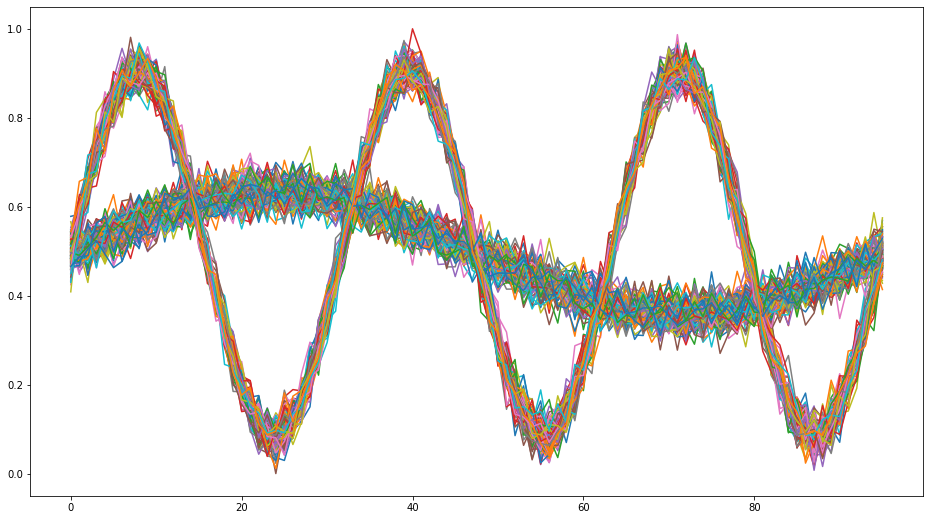

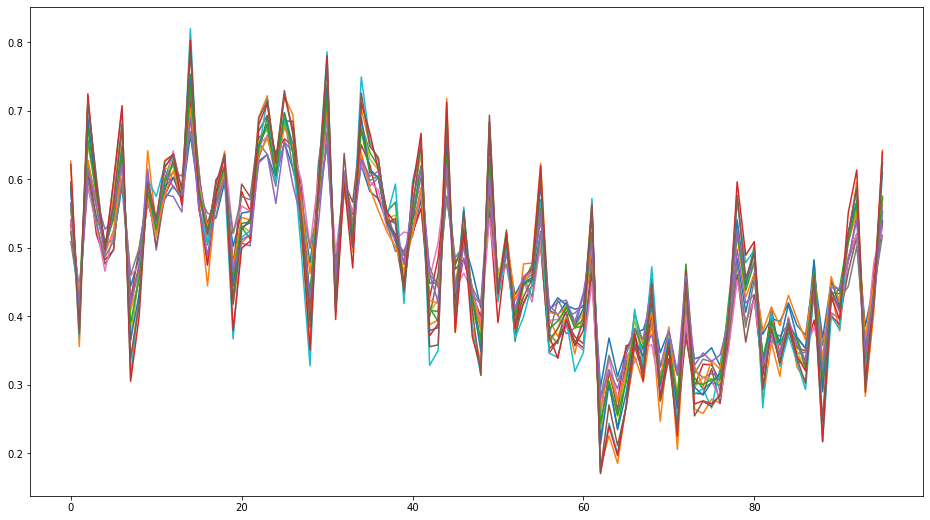

In [19]:
#hide

generator = GANMLP([n_z, n_hidden*len_ts, n_in*len_ts], embedding_module=emb)
discriminator = GANMLP([n_in*len_ts, n_hidden*len_ts], final_act_fct=nn.ReLU)
discriminator = AuxiliaryDiscriminator(basic_discriminator=discriminator, n_classes=n_classes, final_input_size=n_hidden, len_ts=len_ts)
gen_opt = torch.optim.Adam(generator.parameters())
dis_opt = torch.optim.Adam(discriminator.parameters())
model = GAN(generator, discriminator, gen_opt, dis_opt, n_z=n_z, auxiliary=True, auxiliary_weighting_factor=1)
print(model)

data = SineDataset(n_samples, n_classes, n_features, len_ts)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

for e in tqdm(range(epochs)):
    for x_cat, x_cont, y in dl:
        x_cat = x_cat.to(model.device).long()
        x_cont = x_cont.to(model.device)
        y = y.to(model.device)

        model.train_discriminator(x_cat, x_cont, y)
        model.train_generator(x_cat, x_cont, y)

plt.figure()
plt.plot(model.real_loss, label='Real Loss')
plt.plot(model.fake_loss, label='Fake Loss')
plt.legend()
plt.show()

#assert(np.abs(model.real_loss[-1] - model.fake_loss[-1]) < 0.1)

z = model.noise(x_cont)
x_fake = model.generator(x_cat, z)
assert((x_fake - x_cont).mean().abs().item() < 0.5)

plot_sine_samples(dl)
plt.figure(figsize=(16, 9))
for idx in range(x_fake.shape[0]):
    plt.plot(x_fake.squeeze(1)[idx, :].cpu().detach().numpy())
plt.show()

In [20]:
# export

#def get_gan_model(gan_type, model_type, structure, len_ts=1, n_classes=1, n_z=100, emb_module=None):
#    gen_structure = structure.copy()
#    structure.reverse()
#    dis_structure = structure
#    dis_structure[-1] = 1
#    n_z = gen_structure[0]
#    
#    if model_type == 'mlp':
#        model_fct = partial(GANMLP, len_ts=len_ts)
#    elif model_type == 'cnn':
#        model_fct = partial(GANCNN, n_z=n_z, len_ts=len_ts)
#    
#    if gan_type == 'bce' or gan_type == 'aux':
#        final_act_dis = nn.Sigmoid
#        opt_fct = torch.optim.Adam
#        gan_class = GAN
#    elif gan_type == 'wgan':
#        final_act_dis = None
#        opt_fct = torch.optim.RMSprop
#        gan_class = WGAN
#       
#    generator = model_fct(ann_structure=gen_structure, act_fct=nn.ReLU, final_act_fct=nn.Sigmoid, transpose=True, embedding_module=emb_module)
#    if gan_type == 'aux':
#        auxiliary = True
#        final_input_size = dis_structure[-1]*len_ts if model_type=='mlp' else dis_structure[-1]
#        discriminator = model_fct(ann_structure=dis_structure, act_fct=nn.LeakyReLU, final_act_fct=final_act_dis)
#        discriminator = AuxiliaryDiscriminator(basic_discriminator=discriminator, n_classes=n_classes, final_input_size=final_input_size, len_ts=len_ts)  
#    else:
#        auxiliary = False
#        discriminator = model_fct(ann_structure=dis_structure, act_fct=nn.LeakyReLU, final_act_fct=final_act_dis)
#        
#    gen_opt = opt_fct(params=generator.parameters())
#    dis_opt = opt_fct(params=discriminator.parameters())
#    model = gan_class(generator=generator, discriminator=discriminator, gen_optim=gen_opt, dis_optim=dis_opt, n_z=n_z, auxiliary=auxiliary)
#
#    return model

In [21]:
#hide

#n_dim = 2
#
#data = DummyDataset(n_samples=100, n_cat_feats=n_in, n_cont_feats=n_in, n_targets=1, n_dim=n_dim)
#dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)
#
#for x_cat, x_cont, y in dl:
#    print(x_cat.shape, x_cont.shape, y.shape)
#    break
#
#model_type = 'mlp'
#for gan_type in ['bce', 'aux', 'wgan']:
#    model = get_gan_model(gan_type, model_type, structure=[n_z, n_hidden, n_in])
#    print(gan_type)
#    print(model(x_cat, x_cont)[0].shape)
#    if gan_type == 'aux':
#        print(model(x_cat, x_cont)[1].shape)

In [22]:
#hide

#len_ts = 24
#
#data = SineDataset(n_samples=1000, n_classes=2, n_features=2, len_ts=len_ts, noise=0.05)
#dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)
#
#for x_cat, x_cont, y in dl:
#    print(x_cat.shape, x_cont.shape, y.shape)
#    break
#
#model_type = 'mlp'
#for gan_type in ['bce', 'aux', 'wgan']:
#    model = get_gan_model(gan_type, model_type, structure=[n_z, n_hidden, n_in], len_ts=len_ts)
#    print(model)
#    print(gan_type)
#    print(model(x_cat, x_cont)[0].shape)
#    if gan_type == 'aux':
#        print(model(x_cat, x_cont)[1].shape)

In [23]:
# hide

#n_dim = 3
#
#data = DummyDataset(n_samples=100, n_cat_feats=n_in, n_cont_feats=n_in, n_targets=1, n_dim=n_dim)
#dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)
#
#for x_cat, x_cont, y in dl:
#    print(x_cat.shape, x_cont.shape, y.shape)
#    break
#
#model_type = 'cnn'
#for gan_type in ['bce', 'aux', 'wgan']:
#    model = get_gan_model(gan_type, model_type, structure=[n_hidden, n_hidden, n_in], len_ts=24, n_classes=2, n_z=n_z)
#    print(gan_type)
#    print(model(x_cat, x_cont)[0].shape)
#    if gan_type == 'aux':
#        print(model(x_cat, x_cont)[1].shape)